# Kinematics of [O III]

We will calculate the velocity moments for [O III] to compare with the ones we already calculated for H alpha.  There are some advantages in using [O III] over H alpha:

* There are two lines with a known ratio, which allows checking the intensity zero-point easily
* Thermal broadening is less
* Photospheric absorption is less
* ~It looks like there might be less problem with bad sky subtraction~ *Turns out, not so much :(*

On the other hand, there is at least one disadvantage:

* The spectral resolution is lower (in velocity units)


Load libraries and data cube (identical to earlier notebooks):

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
import astropy.units as u

sns.set_context("talk")
sns.set_color_codes()

In [2]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "ADP.2017-10-16T11_04_19.247.fits"
cube = Cube(str(fitsfilepath))

I have now moved functions for dealing with the velocity moments to a separate library:

In [3]:
import sys
from whispy import moments

Where to save figures and FITS images:

In [4]:
moments.FIGPATH = Path("../../figs")
moments.SAVEPATH = Path("../../data")

## Choose the wavelength range

### Broad overview

First we inspect the spectrum in 6 broad horizontal strips across the image, from south to north.

In [5]:
jstrips = [
    [0, 50],
    [50, 100],
    [100, 150],
    [150, 200],
    [200, 250],
    [250, -1],
]

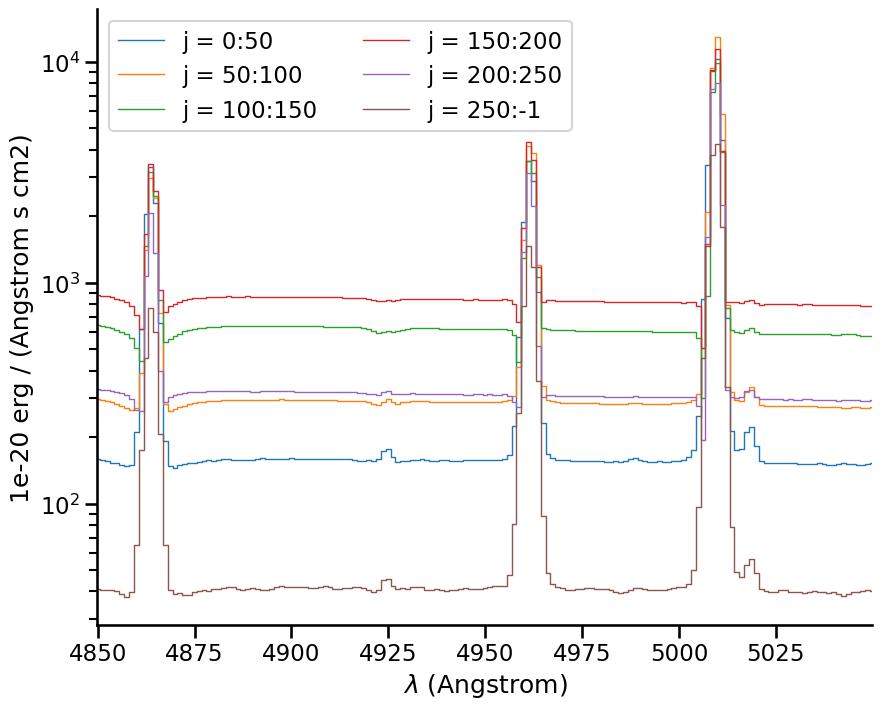

In [6]:
wide_band = cube.select_lambda(4850, 5050)
fig, ax = plt.subplots(figsize=(10, 8))
for (j1, j2) in jstrips:
    (wide_band[:, j1:j2, :].mean(axis=(1, 2)).plot(label=f"j = {j1}:{j2}"))
ax.legend(ncol=2)
ax.set(yscale="log")
sns.despine()

So, this makes it look like all the lines are positive (but this is unfortunately not the case!).  The other weak lines that we see are He I 4922 and 5016 Å.

### Narrow in on the [O III] doublet

Set some limits for the continuum and line extraction:

In [7]:
wlim = {
    "4959": {
        "core": [4953.0, 4969.0],
        "blue": [4947.0, 4953.0],
        "red": [4969.0, 4975.0],
    },
    "5007": {
        "core": [5002.0, 5016.0],
        "blue": [4995.0, 5001.0],
        "red": [5022.0, 5028.0],
    },
}
rangecolors = {"core": "g", "blue": "b", "red": "r"}

Plot these limits zoomed in on the two [O III] lines:

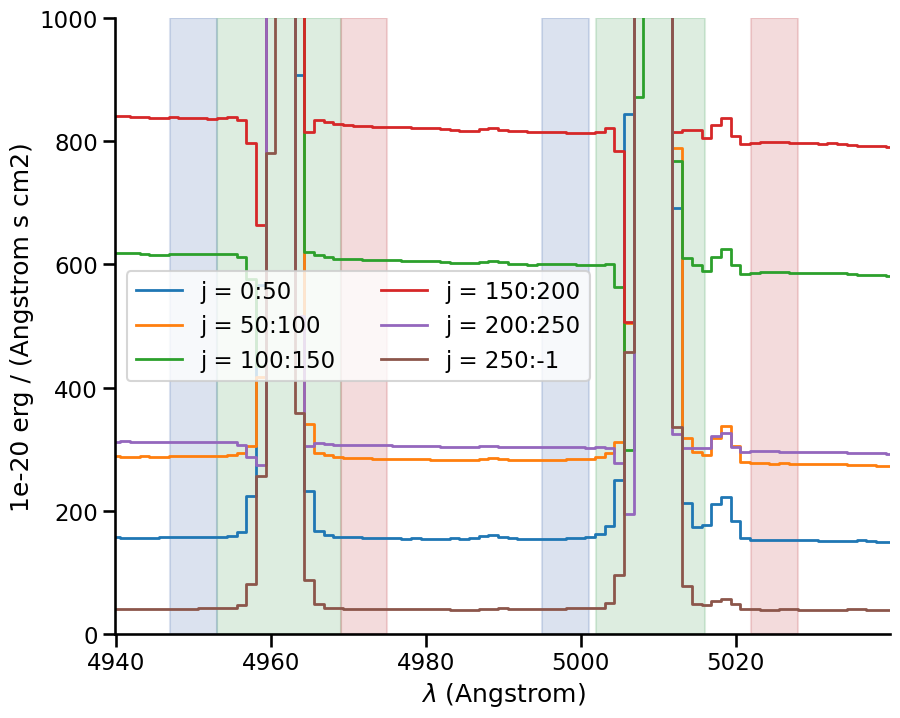

In [8]:
medium_band = cube.select_lambda(4940, 5040)
fig, ax = plt.subplots(figsize=(10, 8))
for (j1, j2) in jstrips:
    (
        medium_band[:, j1:j2, :]
        .mean(axis=(1, 2))
        .plot(label=f"j = {j1}:{j2}", linewidth=2)
    )

for line, linedata in wlim.items():
    for span, spandata in linedata.items():
        ax.axvspan(
            spandata[0], spandata[1], alpha=0.2, color=rangecolors[span], zorder=-100
        )
ax.legend(ncol=2)
ax.set(yscale="linear", ylim=[0.0, 1000])
sns.despine()

That seems to look fine.  Note that the red continuum band for 5007 is separated a bit from the core to allow space for the He I line (although it is so weak that this probably doesn't matter).

### Do continuum subtraction

Now, we can use the same `wlim` data to extract the line and continuum:

In [9]:
def extract_core_and_cont(cube, spandata):
    """Return continuum-subtracted line core and continuum map

    The line core is a 3D cube over the narrow core wavelengths
    """
    cblue = cube.select_lambda(*spandata["blue"]).mean(axis=0)
    cred = cube.select_lambda(*spandata["red"]).mean(axis=0)
    cont = 0.5 * (cblue + cred)
    core = cube.select_lambda(*spandata["core"]) - cont
    return core, cont

In [10]:
core5007, cont5007 = extract_core_and_cont(medium_band, wlim["5007"])
core4959, cont4959 = extract_core_and_cont(medium_band, wlim["4959"])

Plot the line core and the continuum for 5007 and 4959

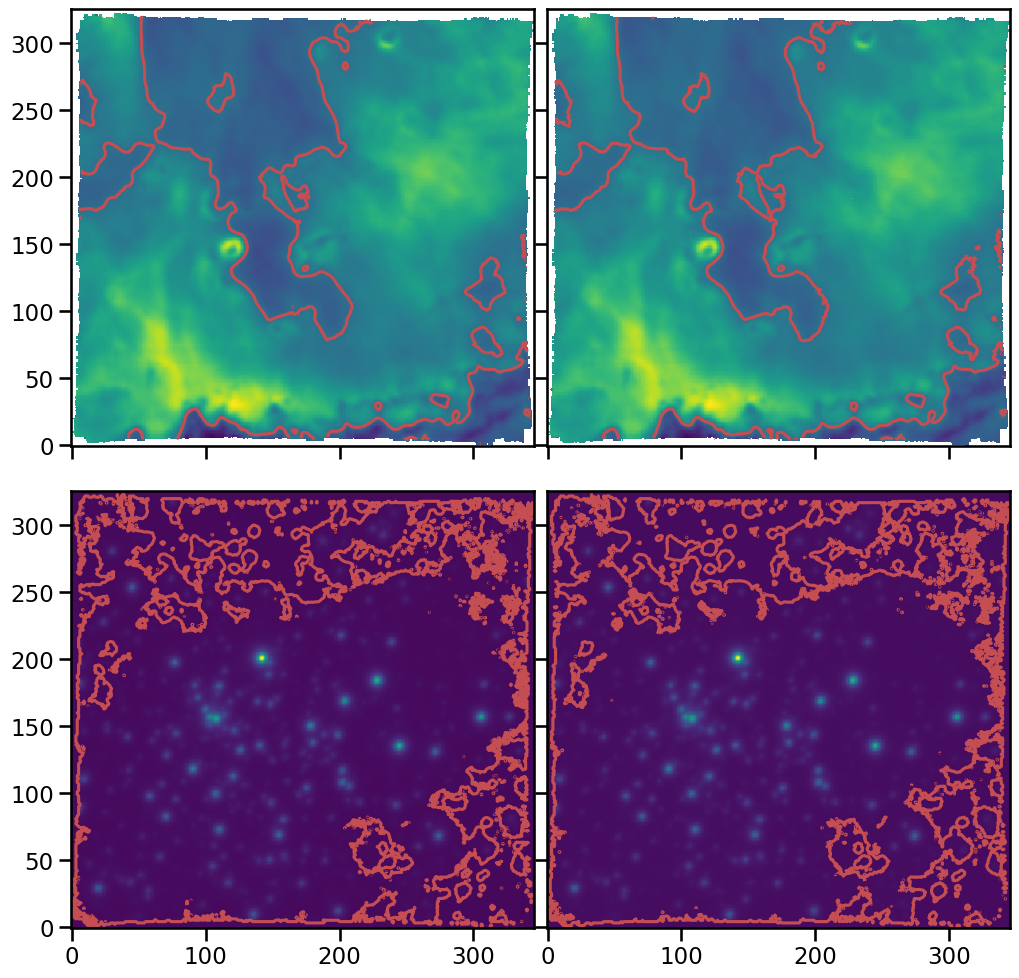

In [11]:
fig, axes = plt.subplots(
    2,
    2,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
)
core5007.sum(axis=0).plot(ax=axes[0, 0])
core4959.sum(axis=0).plot(ax=axes[0, 1])
cont5007.plot(ax=axes[1, 0], scale="sqrt")
cont4959.plot(ax=axes[1, 1], scale="sqrt")
axes[0, 0].contour(core5007.sum(axis=0).data, levels=[0.0], colors="r")
axes[0, 1].contour(core4959.sum(axis=0).data, levels=[0.0], colors="r")
axes[1, 0].contour(cont5007.data, levels=[0.0], colors="r")
axes[1, 1].contour(cont4959.data, levels=[0.0], colors="r")
fig.tight_layout(pad=0)

The red contours show the zero level.  Both lines pass through zero in exactly the same place.  The two continuum maps also have negative regions, but they are completely unrelated to in the line maps (although very similar between themsleves).

## Wavelength moments

We now use the functions defined in my `moments` module (part of whispy package).

### First look without having fixed the sky

This comes out bad because of the zero crossing of the intensity

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


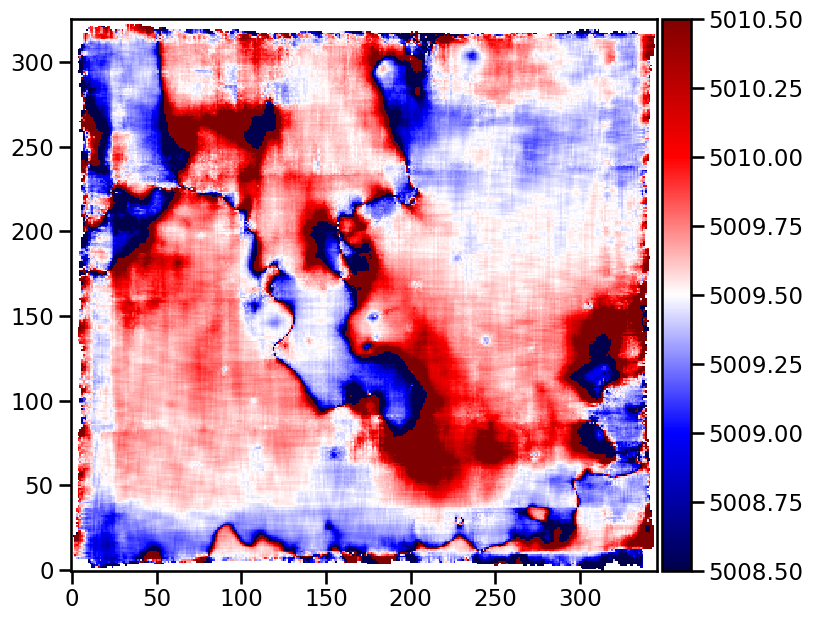

In [12]:
mom5007 = moments.find_moments(core5007)
fig, ax = plt.subplots(figsize=(8, 8))
mom5007[1].plot(
    cmap="seismic",
    vmin=5008.5,
    vmax=5010.5,
    colorbar="v",
)

This looks remarkably similar to the Ha moment map before correction

### Make the correction for the bad sky subtraction

We will first assume that we can correct with exactly the same 3 pixels as we used for H alpha:

In [13]:
skyspec5007 = core5007[:, 8:9, 103:106].mean(axis=(1, 2))
skyspec4959 = core4959[:, 8:9, 103:106].mean(axis=(1, 2))

Inspect the profile in the sky pixels:

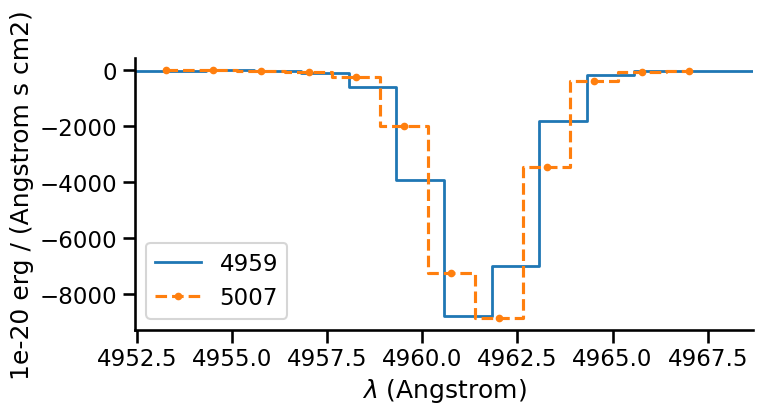

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
skyspec4959.plot(ax=ax, label="4959", linewidth=2)
ax.plot(
    skyspec5007.wave.coord() + (4958.91 - 5006.84),
    skyspec5007.data / 3.0,
    label="5007",
    linestyle="--",
    marker=".",
    drawstyle="steps-mid",
)
# skyspec5007.plot(ax=ax, label="5007", linestyle="--")
ax.legend()
fig.tight_layout()
sns.despine()

Note that I have shifted the 5007 line to match up the rest wavelengths and divided the intensity by 3.  The lines agree very well.

Note also the displacement in wavelength bin centers in their respective rest wavelength frame.  In principle, we could take advantage of this to more finely sample the line profile.

Now look at the effect of the sky correction on a similar sample of pixels as those that we used for H alpha.  I have changed the bottom row ones, in order to find pixels that were truly bright in [O III]:

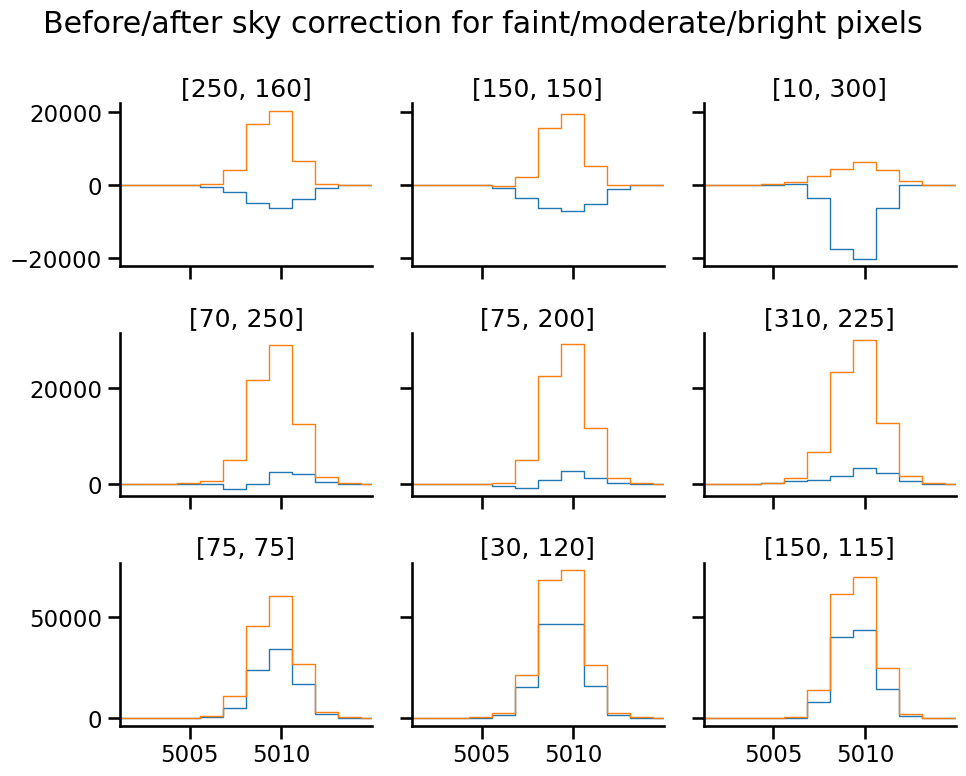

In [15]:
testpixels = [
    [250, 160],
    [150, 150],
    [10, 300],
    [70, 250],
    [75, 200],
    [310, 225],
    [75, 75],
    [30, 120],
    [150, 115],  # [180, 290],
]
fig, axes = plt.subplots(
    3,
    3,
    figsize=(10, 8),
    sharex=True,
    sharey="row",
)
for (j, i), ax in zip(testpixels, axes.flat):
    core5007[:, j, i].plot(ax=ax)
    (core5007[:, j, i] - skyspec5007).plot(ax=ax)
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"[{j}, {i}]")
fig.suptitle("Before/after sky correction for faint/moderate/bright pixels")
sns.despine()
fig.tight_layout()

Apart from the brightest pixels (bottom row), the correction is very substantial.

### Recalculate the moments after correcting the sky

Side-by-side comparison of the first moment for 5007 and 4959:

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


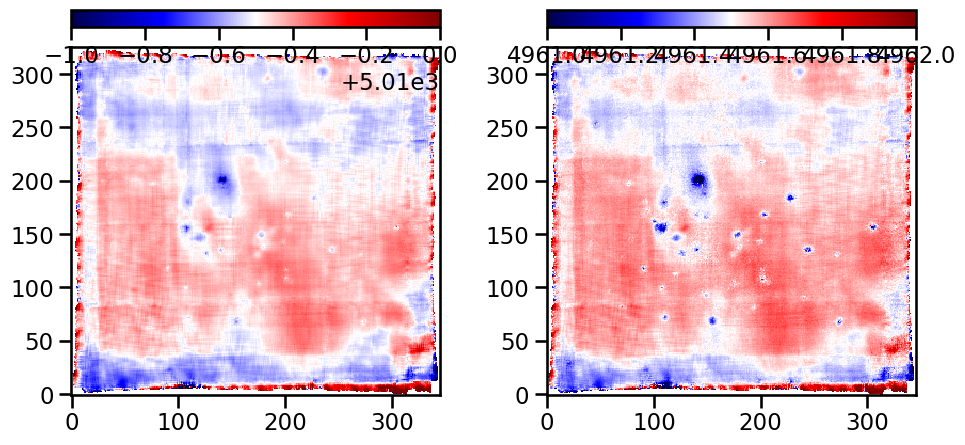

In [16]:
mom5007 = moments.find_moments(core5007 - skyspec5007)
mom4959 = moments.find_moments(core4959 - skyspec4959)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
mom5007[1].plot(
    cmap="seismic",
    vmin=5009.0,
    vmax=5010.0,
    colorbar="h",
    ax=axes[0],
)
mom4959[1].plot(
    cmap="seismic",
    vmin=4961.0,
    vmax=4962.0,
    colorbar="h",
    ax=axes[1],
)
fig.tight_layout(h_pad=10)

These look very similar to the H alpha map in general.  They are also extremely similar to one another.  Both of these facts are reassuring.

On the negative side, there do be some artefacts, particularly horizontal stripes. These tend to occur at "significant" j values, such as 80, 160, 240, which correspond to different IFUs I think.

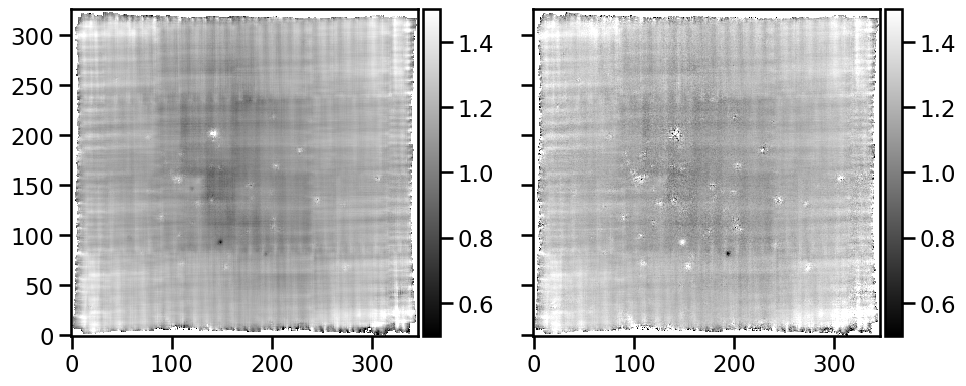

In [17]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    sharey=True,
)
mom5007[2].plot(
    cmap="gray",
    vmin=0.5,
    vmax=1.5,
    colorbar="v",
    ax=axes[0],
)
mom4959[2].plot(
    cmap="gray",
    vmin=0.5,
    vmax=1.5,
    colorbar="v",
    ax=axes[1],
)
fig.tight_layout()

(5009.515955413344, 4961.538355783659)

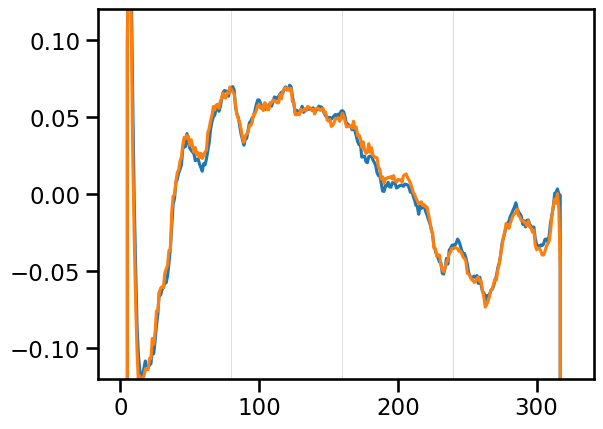

In [18]:
fig, ax = plt.subplots()
wav5007 = np.median(mom5007[1].data.data)
wav4959 = np.median(mom4959[1].data.data)
# ax.plot(mom5007[1].data.mean(axis=1) - wav5007)
# ax.plot(mom4959[1].data.mean(axis=1) - wav4959)
ax.plot(np.median(mom5007[1].data.data, axis=1) - wav5007)
ax.plot(np.median(mom4959[1].data.data, axis=1) - wav4959)
ax.set(ylim=[-0.12, 0.12])
for i0 in [80, 160, 240]:
    ax.axvline(i0, lw=0.5, color="k", alpha=0.2)
wav5007, wav4959

[(-0.12, 0.12)]

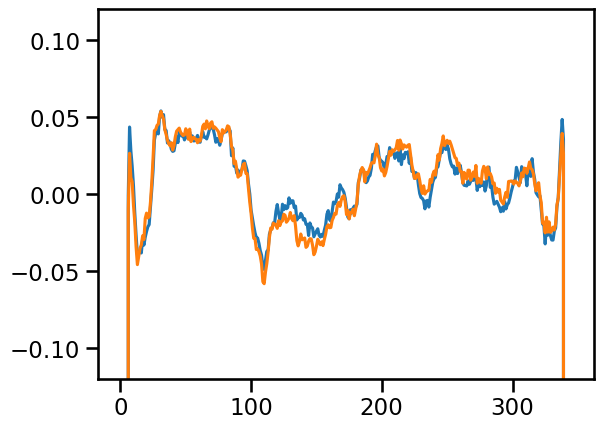

In [19]:
fig, ax = plt.subplots()
ax.plot(np.median(mom5007[1].data.data, axis=0) - wav5007)
ax.plot(np.median(mom4959[1].data.data, axis=0) - wav4959)
# ax.plot(mom5007[1].data.mean(axis=0) - wav5007)
# ax.plot(mom4959[1].data.mean(axis=0) - wav4959)
ax.set(ylim=[-0.12, 0.12])
# for i0 in [80, 160, 240]:
#    ax.axvline(i0, lw=0.5, color="k", alpha=0.2)

In [20]:
import pandas as pd

In [21]:
moments.save_moments_to_fits(
    mom5007,
    label="5007",
    flabel="ngc346-oiii",
    restwav=5006.84,
    irange=[1.0e4, 3.0e5],
    vrange=[135, 195],
    srange=[50, 90],
)

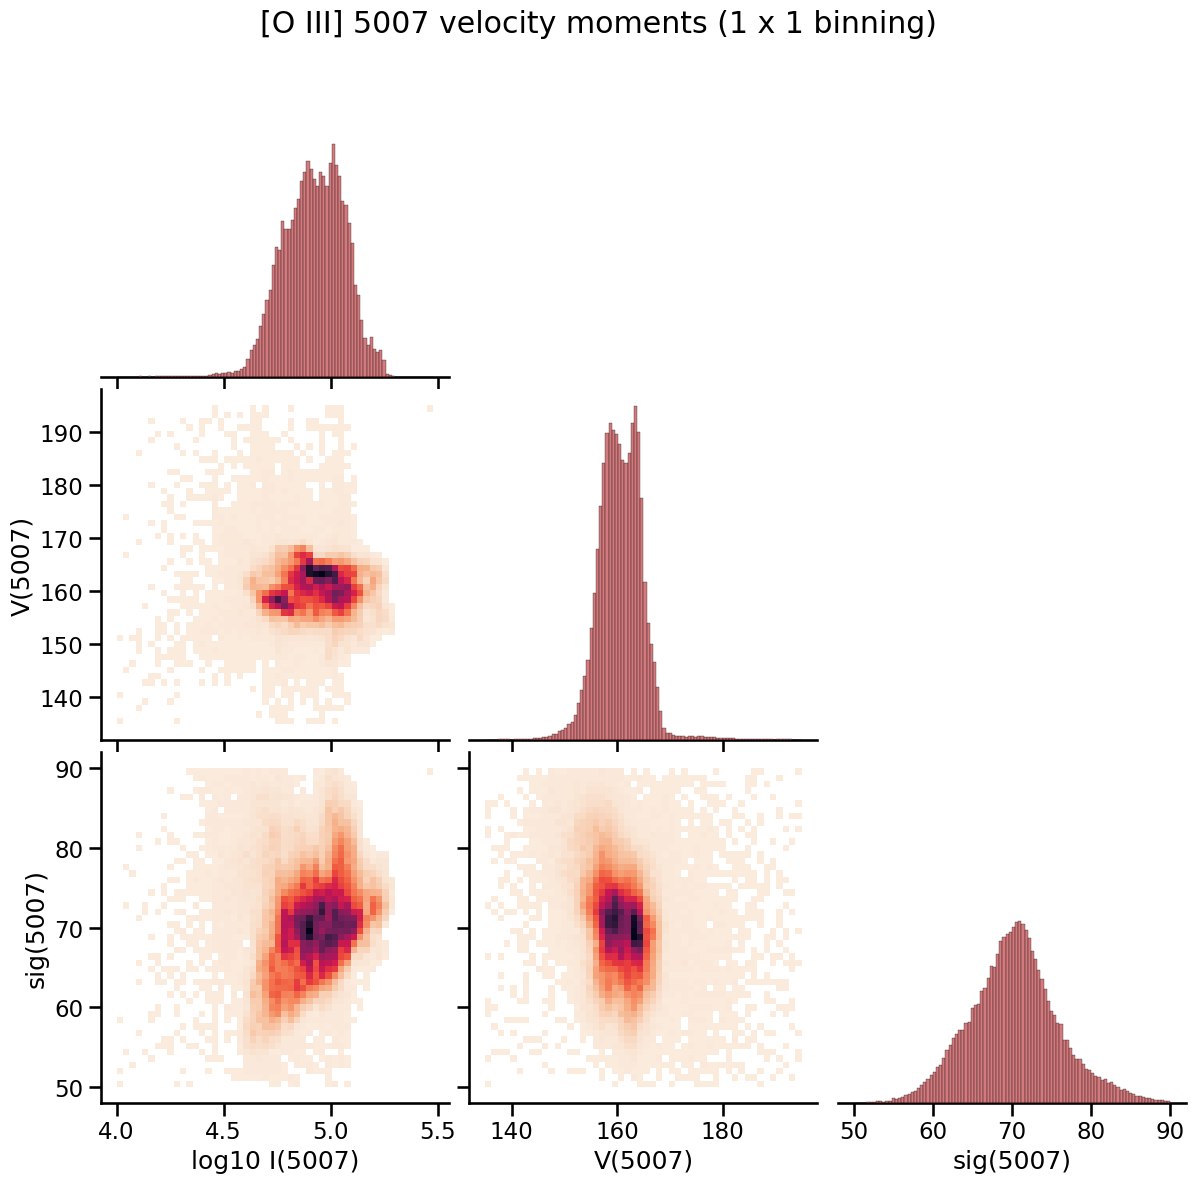

In [22]:
plot_pars_5007 = dict(
    ilabel="[O III]",
    label="5007",
    flabel="ngc346-oiii",
    restwav=5006.84,
    irange=[1.0e4, 3.0e5],
    vrange=[135, 195],
    srange=[50, 90],
)
g = moments.moments_corner_plot(mom5007, rebin=1, **plot_pars_5007)

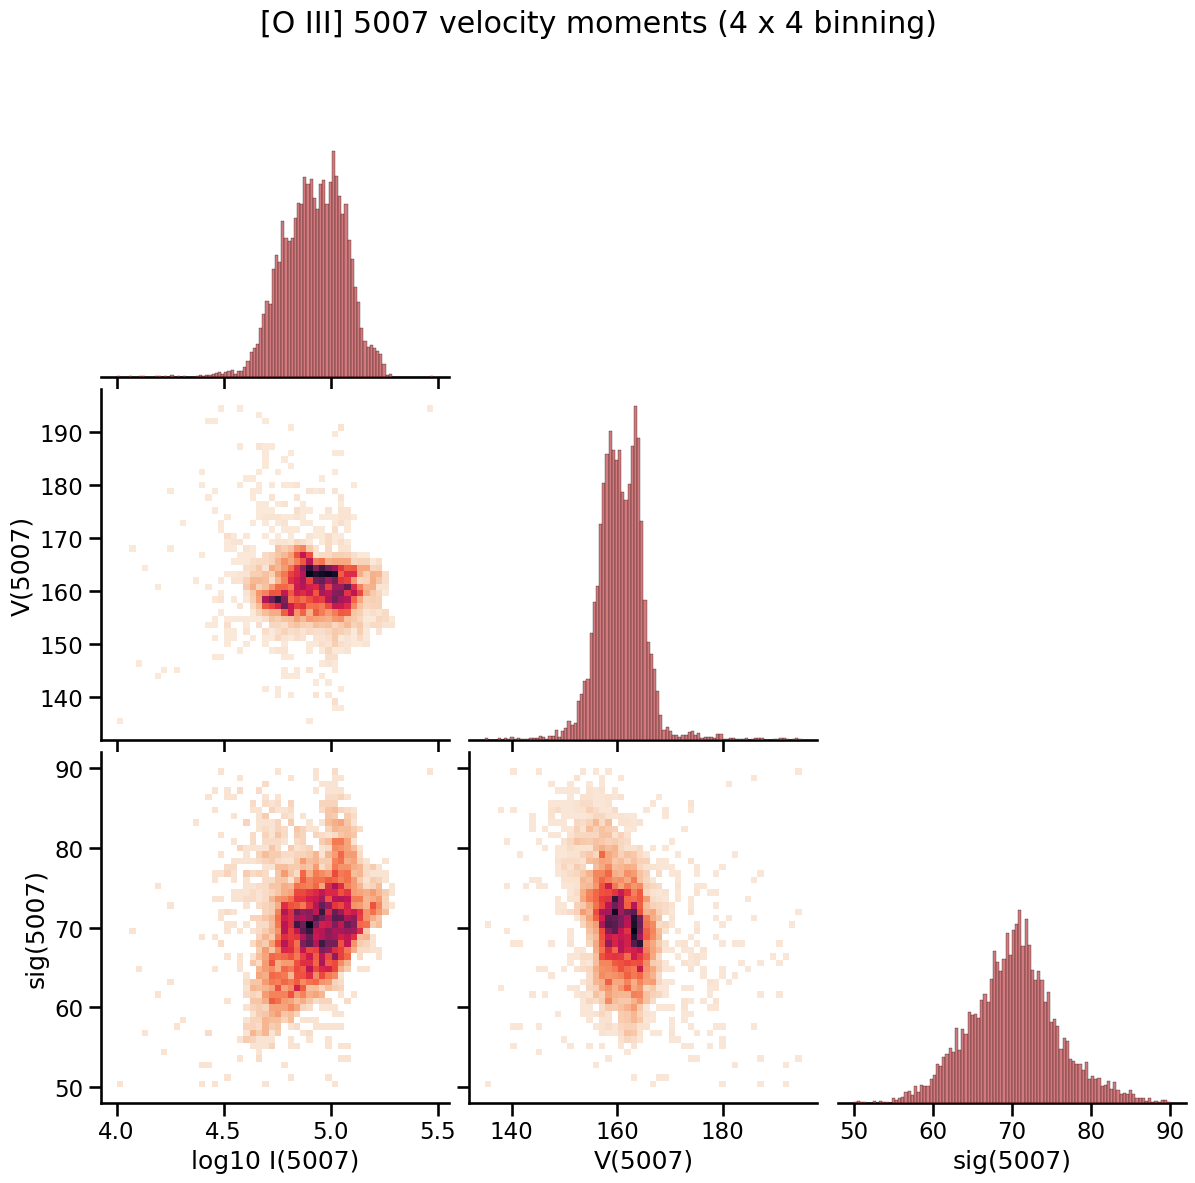

In [23]:
g = moments.moments_corner_plot(mom5007, rebin=4, **plot_pars_5007)

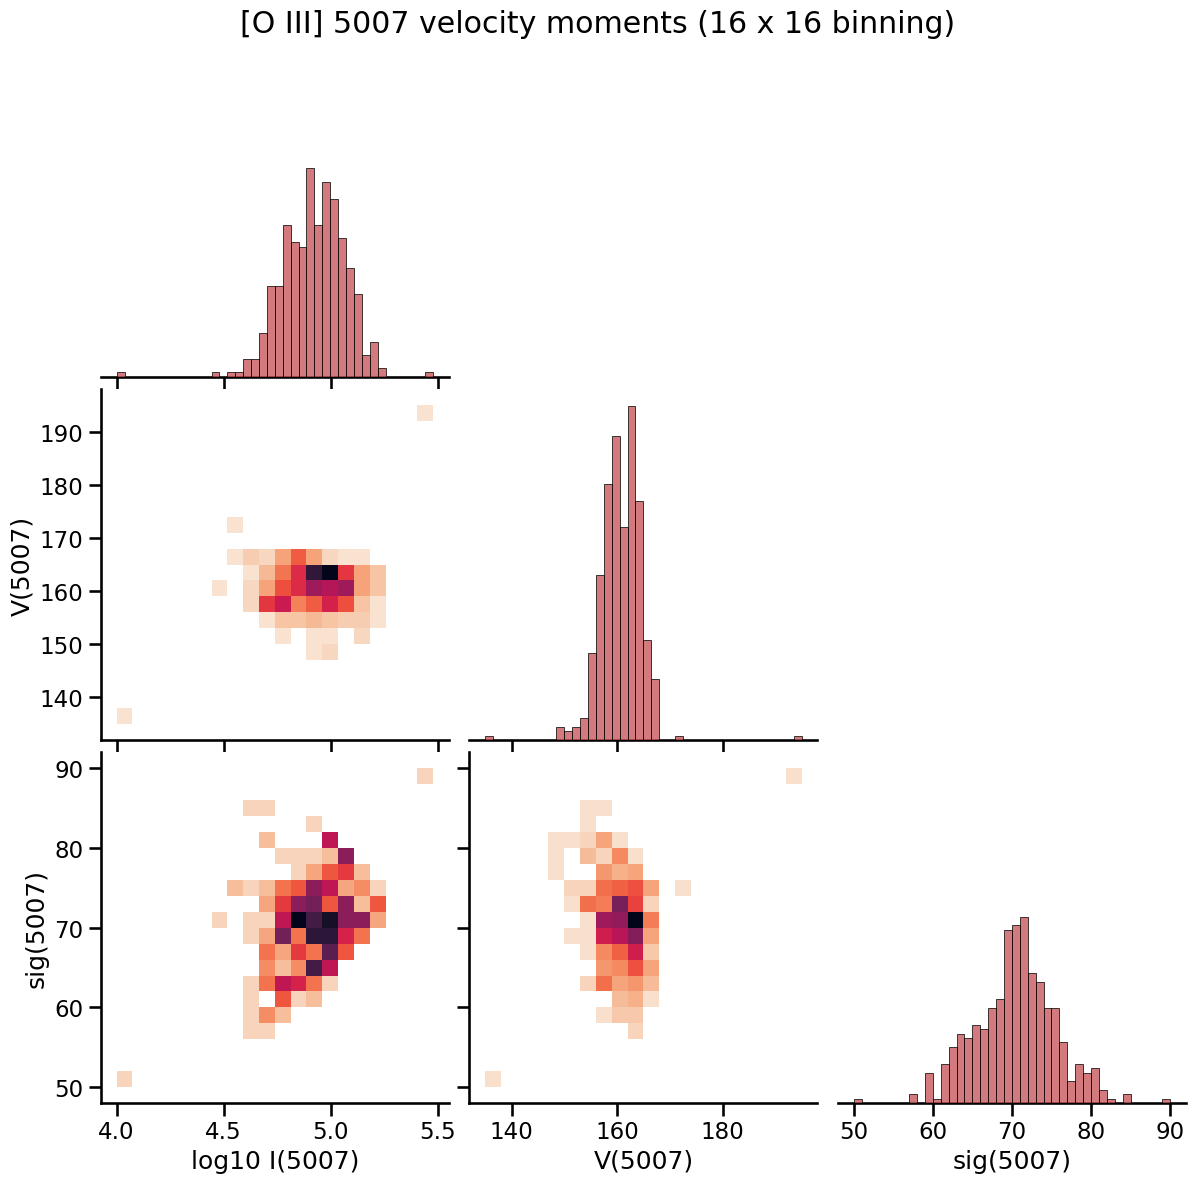

In [24]:
g = moments.moments_corner_plot(
    mom5007,
    rebin=16,
    **plot_pars_5007,
    hist_bins=40,
    image_bins=20,
)

In [25]:
m = (
    mom5007[0].mask
    | (mom5007[0].data < 2e4)
    | (mom5007[1].data < 5009.2)
    | (mom5007[1].data > 5009.8)
    | (mom5007[2].data < 0.8)
    | (mom5007[2].data > 1.5)
)
df = pd.DataFrame(
    {
        "log10 I(5007)": np.log10(mom5007[0].data[~m]),
        "V(5007)": 3e5 * (mom5007[1].data[~m] - 5006.84) / 5006.84,
        "sig(5007)": 3e5 * mom5007[2].data[~m] / 5006.84,
    }
)
df.describe()

,log10 I(5007),V(5007),sig(5007)
count,103785.000000,103785.000000,103785.000000
mean,4.923039,160.667440,70.423614
std,0.139926,3.951481,5.712461
min,4.305198,141.459858,48.015065
25%,4.824004,158.039236,66.792234
50%,4.928227,160.699411,70.376597
75%,5.026888,163.510750,73.752321
max,5.291500,177.349047,89.871209


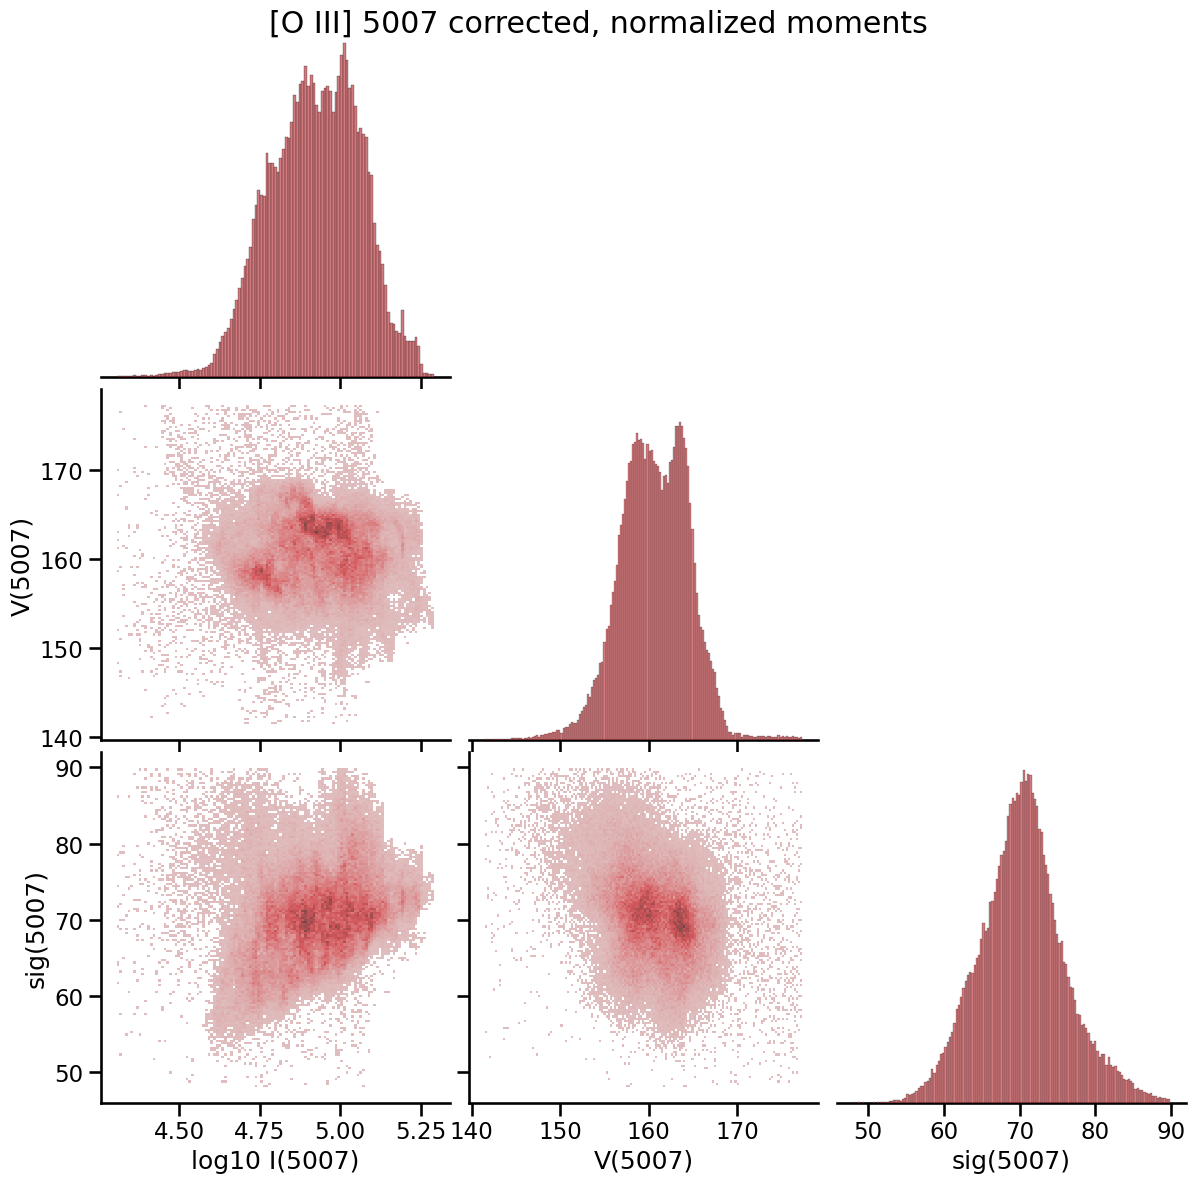

In [26]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="r"),
    diag_kws=dict(color="r"),
)
g.fig.suptitle("[O III] 5007 corrected, normalized moments")
g.tight_layout(pad=0)

In [27]:
m = (
    mom4959[0].mask
    | (mom4959[0].data < 0.67e4)
    | (mom4959[1].data < 4961.2)
    | (mom4959[1].data > 4961.8)
    | (mom4959[2].data < 0.8)
    | (mom4959[2].data > 1.5)
)
df4959 = pd.DataFrame(
    {
        "log10 I(4959)": np.log10(mom4959[0].data[~m]),
        "V(4959)": 3e5 * (mom4959[1].data[~m] - 4958.91) / 4958.91,
        "sig(4959)": 3e5 * mom4959[2].data[~m] / 4958.91,
    }
)
df4959.describe()

,log10 I(4959),V(4959),sig(4959)
count,102735.000000,102735.000000,102735.000000
mean,4.449650,159.260461,74.547042
std,0.137717,4.002275,5.506318
min,3.826466,138.597412,48.587818
25%,4.351719,156.541333,70.979660
50%,4.454385,159.418835,74.349886
75%,4.551768,162.196549,77.866032
max,4.814876,174.831652,90.744251


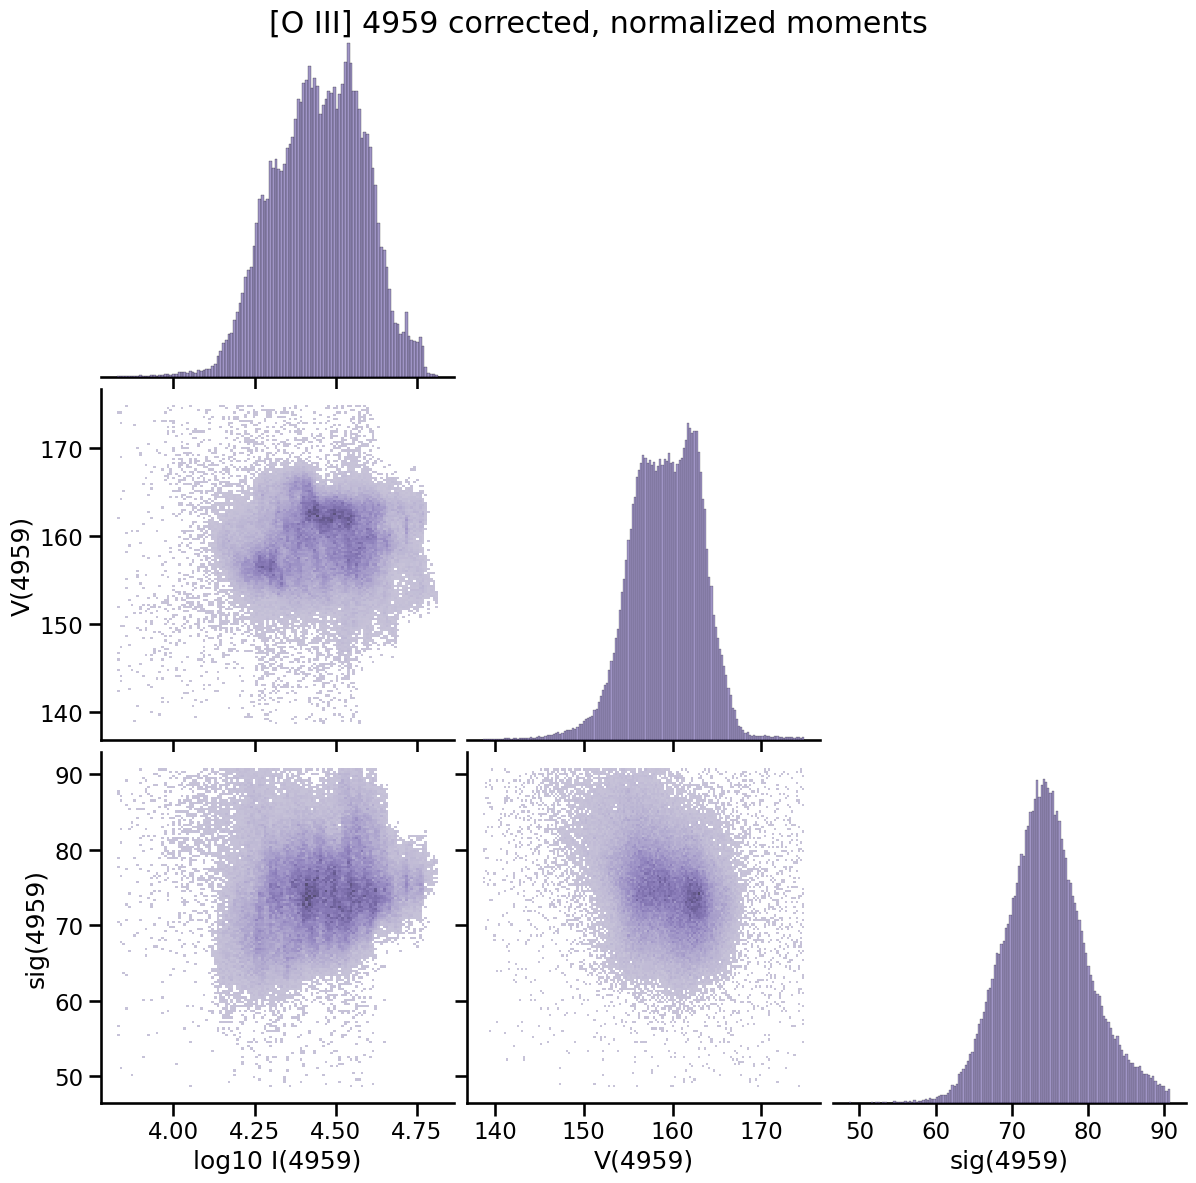

In [28]:
g = sns.pairplot(
    df4959,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="m"),
    diag_kws=dict(color="m"),
)
g.fig.suptitle("[O III] 4959 corrected, normalized moments")
g.tight_layout(pad=0)

The distributions are very consistent between the two [O III] lines.  They are also quite similar to H alpha, especially in the mid-range of intensity.

There is clear evidence for a bimodal distribution of velocities, separated by about 6 km/s. A narrow component at 164 km/s and a broader component at 158 km/s. Then there is a third, weaker component at 166 km/s.  These are all from 5007 - the same is seen for 4959, but with a shift of -2 km/s.  Width is also higher for 4959 - could this be due to a blend with something?

There is a very slight reduction in line width with velocity, which is seen in all the lines.

Now look at the cross-correlations between the two lines:

In [29]:
m = (
    mom5007[0].mask
    | (mom5007[0].data < 2e4)
    | (mom5007[1].data < 5009.2)
    | (mom5007[1].data > 5009.8)
    | (mom5007[2].data < 0.8)
    | (mom5007[2].data > 1.5)
    | mom4959[0].mask
    | (mom4959[0].data < 0.67e4)
    | (mom4959[1].data < 4961.2)
    | (mom4959[1].data > 4961.8)
    | (mom4959[2].data < 0.8)
    | (mom4959[2].data > 1.5)
)
df2 = pd.DataFrame(
    {
        "log10 I(5007)": np.log10(mom5007[0].data[~m]),
        "V(5007)": 3e5 * (mom5007[1].data[~m] - 5006.84) / 5006.84,
        "sig(5007)": 3e5 * mom5007[2].data[~m] / 5006.84,
        "log10 I(4959)": np.log10(mom4959[0].data[~m]),
        "V(4959)": 3e5 * (mom4959[1].data[~m] - 4958.91) / 4958.91,
        "sig(4959)": 3e5 * mom4959[2].data[~m] / 4958.91,
    }
)
df2.corr()

,log10 I(5007),V(5007),sig(5007),log10 I(4959),V(4959),sig(4959)
log10 I(5007),1.000000,-0.010872,0.318474,0.999700,0.093539,0.148223
V(5007),-0.010872,1.000000,-0.312480,-0.010804,0.941833,-0.299436
sig(5007),0.318474,-0.312480,1.000000,0.317768,-0.249610,0.899916
log10 I(4959),0.999700,-0.010804,0.317768,1.000000,0.093448,0.151247
V(4959),0.093539,0.941833,-0.249610,0.093448,1.000000,-0.291065
sig(4959),0.148223,-0.299436,0.899916,0.151247,-0.291065,1.000000


In [30]:
xvars = [_ for _ in df2.columns if "5007" in _]
yvars = [_ for _ in df2.columns if "4959" in _]
xvars, yvars

(['log10 I(5007)', 'V(5007)', 'sig(5007)'],
 ['log10 I(4959)', 'V(4959)', 'sig(4959)'])

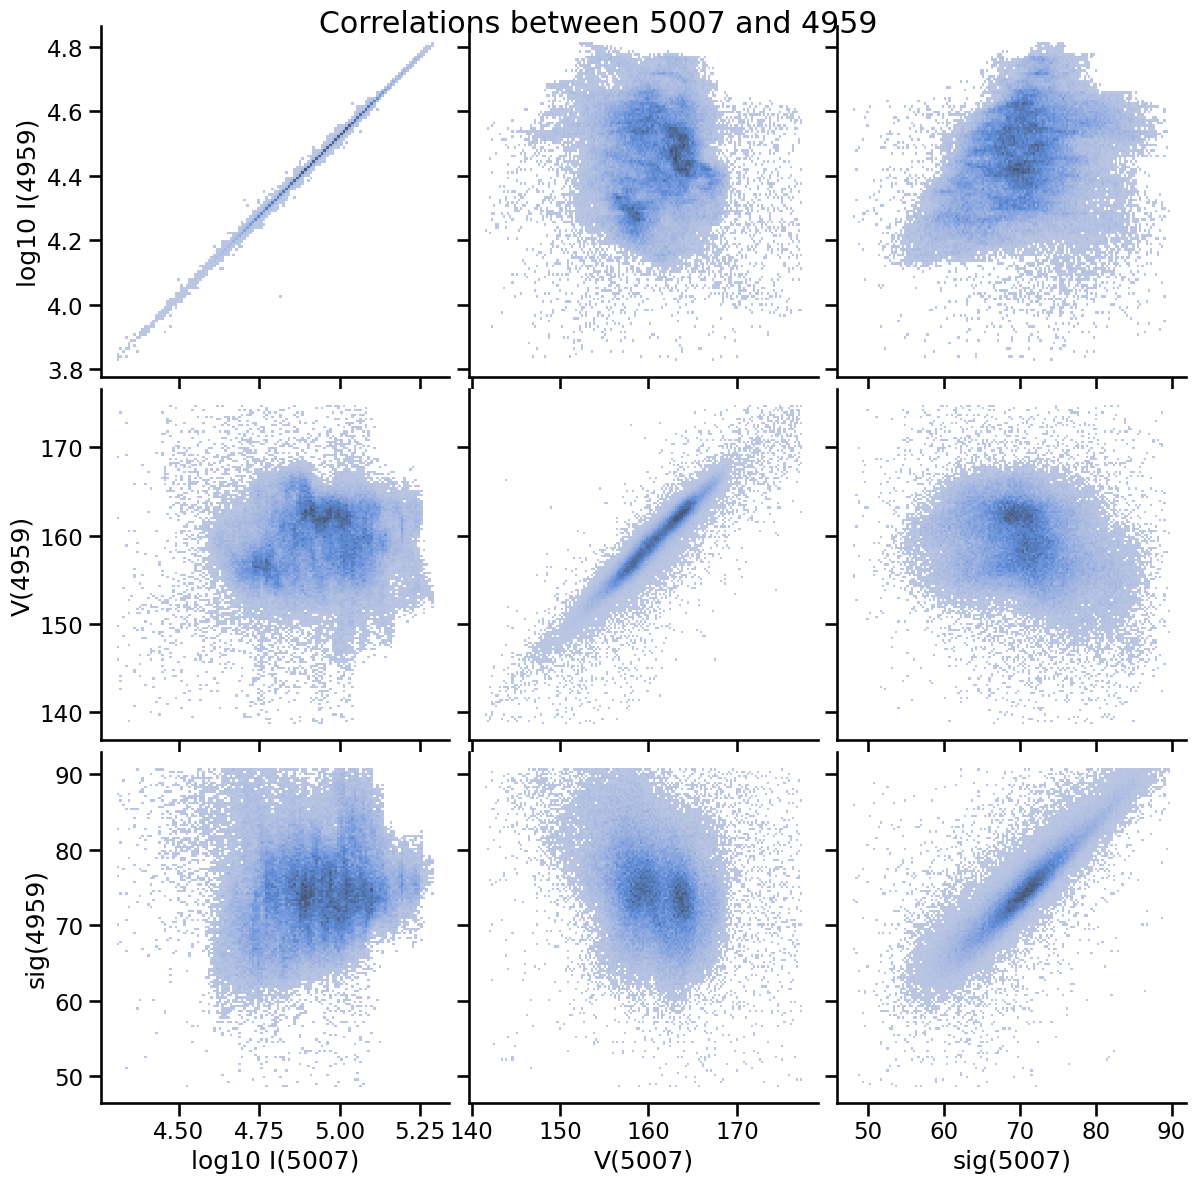

In [31]:
g = sns.pairplot(
    df2,
    kind="hist",
    height=4,
    x_vars=xvars,
    y_vars=yvars,
    plot_kws=dict(color="b"),
)
g.fig.suptitle("Correlations between 5007 and 4959")
g.tight_layout(pad=0)

In [32]:
df3 = df2[["log10 I(5007)"]].copy()
df3["5007 / 4959"] = 10 ** (df2["log10 I(5007)"] - df2["log10 I(4959)"])
df3["dV"] = df2["V(5007)"] - df2["V(4959)"]
df3["sig ratio"] = df2["sig(5007)"] / df2["sig(4959)"]
df3.describe()

,log10 I(5007),5007 / 4959,dV,sig ratio
count,102480.000000,102480.000000,102480.000000,102480.000000
mean,4.924917,2.984889,1.430742,0.943374
std,0.138295,0.025279,1.336528,0.033484
min,4.306350,2.395435,-22.467486,0.563015
25%,4.826355,2.974008,0.728580,0.928895
50%,4.929564,2.985946,1.340238,0.946517
75%,5.027651,2.996889,1.968301,0.960973
max,5.291500,6.190350,21.576956,1.557836


In [33]:
m = (
    (df3["5007 / 4959"] < 2.9)
    | (df3["5007 / 4959"] > 3.1)
    | (np.abs(df3["dV"]) > 5.0)
    | (df3["sig ratio"] < 0.8)
    | (df3["sig ratio"] > 1.1)
)

df3 = df3[~m]
df3.corr()

,log10 I(5007),5007 / 4959,dV,sig ratio
log10 I(5007),1.000000,0.374854,-0.349738,0.461957
5007 / 4959,0.374854,1.000000,-0.157590,0.465372
dV,-0.349738,-0.157590,1.000000,-0.372824
sig ratio,0.461957,0.465372,-0.372824,1.000000


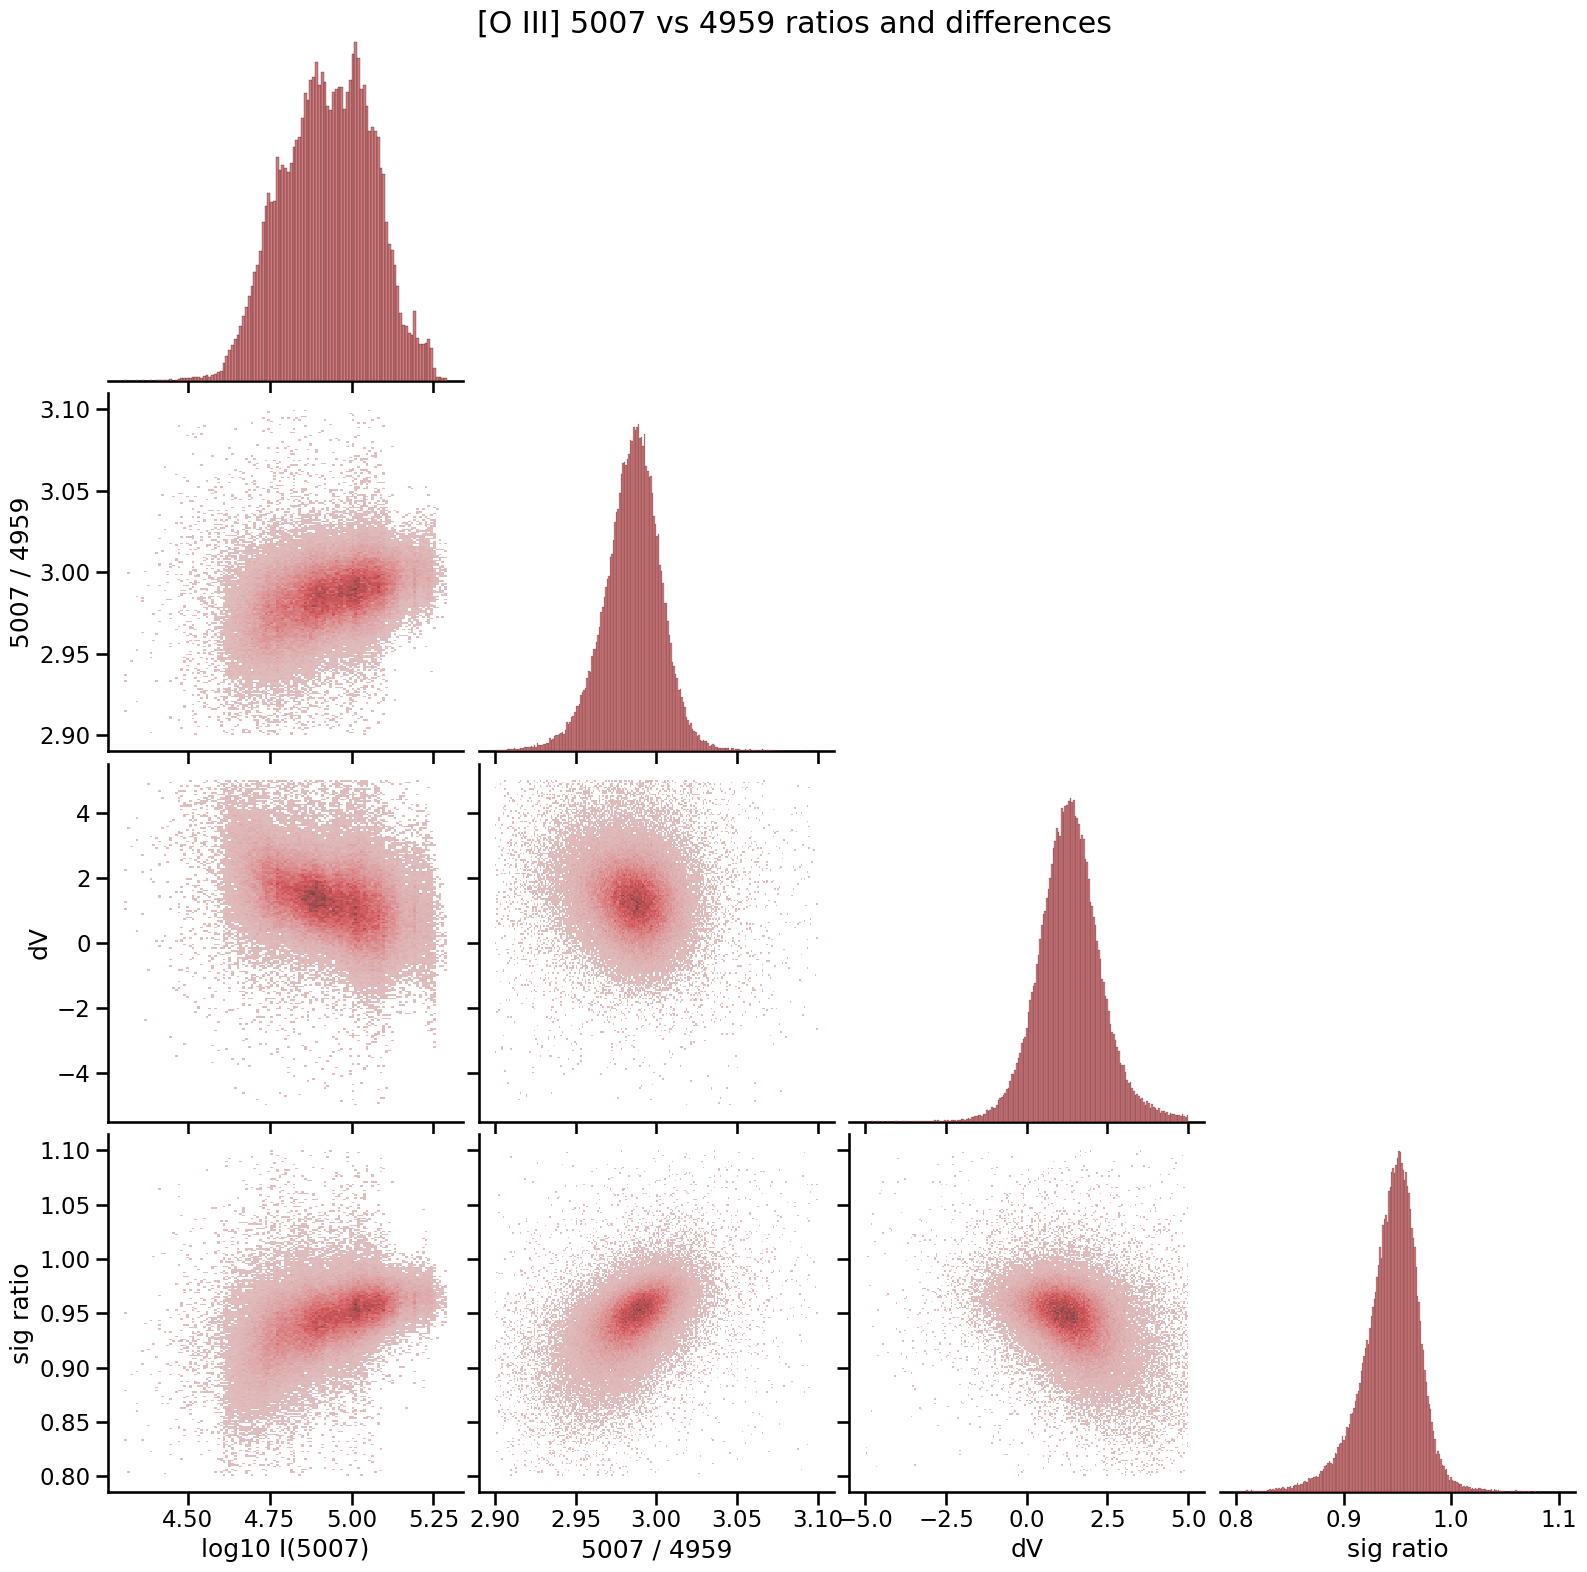

In [34]:
g = sns.pairplot(
    df3,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="r"),
    diag_kws=dict(color="r"),
)
g.fig.suptitle("[O III] 5007 vs 4959 ratios and differences")
g.tight_layout(pad=0)

In [35]:
df3.loc?

Type:        property
String form: <property object at 0x11f265040>
Docstring:  
Access a group of rows and columns by label(s) or a boolean array.

``.loc[]`` is primarily label based, but may also be used with a
boolean array.

Allowed inputs are:

- A single label, e.g. ``5`` or ``'a'``, (note that ``5`` is
  interpreted as a *label* of the index, and **never** as an
  integer position along the index).
- A list or array of labels, e.g. ``['a', 'b', 'c']``.
- A slice object with labels, e.g. ``'a':'f'``.

  .. warning:: Note that contrary to usual python slices, **both** the
      start and the stop are included

- A boolean array of the same length as the axis being sliced,
  e.g. ``[True, False, True]``.
- An alignable boolean Series. The index of the key will be aligned before
  masking.
- An alignable Index. The Index of the returned selection will be the input.
- A ``callable`` function with one argument (the calling Series or
  DataFrame) and that returns valid output for inde